In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
#build vocabulary of characters and mappings to/from intergers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
block_size = 3
def build_dataset(words):
	
	X, Y = [], []
	
	for w in words:
		context = [0] * block_size
		for ch in w + '.':
			ix = stoi[ch]
			X.append(context)
			Y.append(ix)
			#print(''.join(itos[i] for i in context), '--->',itos[ix])
			context =context[1:] + [ix]

	X = torch.tensor(X)
	Y = torch.tensor(Y)
	print(X.shape, Y.shape)
	return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# utility function we will use later to compare our caculated gradients with pytorch autograd
def cmp(s, dt, t):
    ex = torch.all(dt ==t.grad).item()
    app= torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15} | exact: {str(ex):5s} | approximate: {str(app):5s}| maxdiff: {maxdiff}')

In [12]:
#MLP
n_emb = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_emb),				generator=g)
#Layer 1
W1 = torch.randn((n_emb * block_size,n_hidden),	generator=g) * (5/3) / ((n_emb * block_size)**(0.5)) # 3letters(block size)x10 inputs
b1 = torch.randn(n_hidden,						generator=g) * 0.1
#Layer 2
W2 = torch.randn((n_hidden,vocab_size),			generator=g) * 0.1 # initial weights very close to 0 so it gives same probability to all letters
b2 = torch.randn(vocab_size,					generator=g) * 0.1 # we want to start without a bias in the initialization same reason as above
#BatchNorm parameters
bngain = torch.ones((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.zeros((1, n_hidden)) * 0.1
bnmean_running= torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

4137


In [13]:
batch_size = 32
n = batch_size
ix= torch.randint(0, Xtr.shape[0],(batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [14]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at the time

emb = C[Xb] #embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0,keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.crossentropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes #subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
	t.retain_grad()
loss.backward()
loss

tensor(3.3482, grad_fn=<NegBackward0>)

In [9]:
bnmeani.shape, hprebn.shape, bndiff.shape

(torch.Size([1, 64]), torch.Size([32, 64]), torch.Size([32, 64]))

In [ ]:
hprebn.shape, embcat.shape, W1.shape, b1.shape
dembcat= dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)

(torch.Size([32, 64]),
 torch.Size([32, 30]),
 torch.Size([30, 64]),
 torch.Size([64]))

In [18]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

#!!!!!!!!!!!! dh.shape == h.shape !!!!!!!!!!!! That's the trick to find the correct derivates, by playin with the dimensions
logprobs[range(n), Yb].shape

counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 
probs = counts * counts_sum_inv

torch.Size([32])

In [19]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [22]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n 
cmp('logprobs', dlogprobs, logprobs)

# dloss/dprobs = dloss/dlogpros * dlogpros/dprobs
# logprobs = probs.log() -> d(log) = 1/x
dprobs =  1 / probs * dlogprobs
cmp('probs', dprobs, probs)
(counts * dprobs).sum(1, keepdim=True)
counts.shape, dprobs.shape

logprobs        | exact: True  | approximate: True | maxdiff: 0.0
probs           | exact: True  | approximate: True | maxdiff: 0.0


(torch.Size([32, 27]), torch.Size([32, 27]))

In [23]:
logits.shape, logit_maxes.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [27]:
F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]).shape

torch.Size([32, 27])

In [28]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

# -----------------
# YOUR CODE HERE :)
# -----------------
# loss = -logprobs[range(n), Yb].mean()
# loss = -(a + b + c) / 3 = -1/3a -1/3b -1/3c = -1.0 / n
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n 
cmp('logprobs', dlogprobs, logprobs)

# dloss/dprobs = dloss/dlogpros * dlogpros/dprobs
# logprobs = probs.log() -> d(log) = 1/x
dprobs =  1 / probs * dlogprobs
cmp('probs', dprobs, probs)

# dloss/ dcounts_sum_inv = dloss/dprobs * dprobs/dcounts_sum_inv
# probs = counts * counts_sum_inv --> [32,27] * [32,1]
# c = a[3x3] * b[3x1] 
# a11*b1 + a12*b1 + a13*b1
# a21*b2 + a22*b2 + a23*b2
# dc = a11+a12+a13
#       a21+a22+a23 ...
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True) # sum by row (a11+a12+a13)
dcounts = counts_sum_inv * dprobs # chain rule
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

# dcounts_sum_inv/ dcounts_sum
# counts_sum_inv = counts_sum**-1  -> d(1/x) = -1/x**2 
dcounts_sum = 	(-counts_sum**-2) * dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)

#  dcounts_sum / dcounts
# counts_sum = counts.sum(1, keepdims=True)
# counts.shape -> (32,27), counts_sum -> (32,1) -> derivate of a sum is 1
# a11, a12, a13.. -> b3
# a21, a22, a23.. -> b2
# a31, a32, a33.. -> b1
dcounts += torch.ones_like(counts) * dcounts_sum
cmp('counts', dcounts, counts)

# dcounts / dnorm_logits
# counts = norm_logits.exp() -> d(exp(x)) -> exp(x)
dnorm_logits = norm_logits.exp() * dcounts
cmp('norm_logits', dnorm_logits, norm_logits)


# norm_logits = logits - logit_maxes = [32,27] * [32,1]
# c11 c12 c13 = a11 a12 a13  -  b3 (b3 is the maximum of that column)
# c21 c22 c23 = a21 a22 a23  -  b1 
# derivate with respect of ligt_maxes of b3 and b1 is const -1 [32,1]
# dnorm_logits/dlogit
dlogits = 1 * dnorm_logits.clone()
# dnorm_logits/dlogit_maxes
dlogit_maxes = -1 * dnorm_logits.sum(1,keepdim=True) #[32,27]
cmp('logit_maxes', dlogit_maxes, logit_maxes)

# dlogit_maxes/dlogits
# logit_maxes plugs out the max value by column 
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes 
cmp('logits', dlogits, logits)

# Matrix 
#!!!!!!!!!!!! dh.shape == h.shape !!!!!!!!!!!! That's the trick to find the correct derivates, by playin with the dimensions
# logits = h @ W2 + b1
#logits = torch.Size([32, 27]),
# so dlogits =[32,27]
#h = torch.Size([32, 64]),
#w2 = torch.Size([64, 27]),
#b1 = torch.Size([27]))
# by the chain rule dlogits [32,27] needs to be allways on the expression
dh = dlogits @ W2.T  # [32,64] = [32,27] * [64,27].T
dW2 = h.T @ dlogits  # [64,27] =   [32,64] * [32,27]
db2 = dlogits.sum(0) # [27]  = [32,27].sum(0)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
#  
# h = torch.tanh(hpreact) # hidden layer
dhpreact = (1.0 - h**2) * dh
cmp('hpreact', dhpreact, hpreact)
#
##hpreact = bngain * bnraw + bnbias
dbngain = bnraw*dhpreact
# bngain = [1,64] = [32,64] *[32,64] so we need to sum column wise
dbngain = dbngain.sum(0, keepdim=True)

dbnraw = bngain*dhpreact

dbnbias = dhpreact.sum(0, keepdim=True)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)

# dbraw/dbnvar_inv
#bnraw = bndiff * bnvar_inv
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True) #matrix multiplication bndiff * chain rule dnraw
dbndiff = bnvar_inv * dbnraw
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

# bnvar_inv = (bnvar + 1e-5)**-0.5
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv  # rule of derivatives * chain_rule
cmp('bnvar', dbnvar, bnvar)

#bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
# [1,64] = [32,64]
# bnvar = 1/(n-1) * (a11 + a21 + a31)
#         1/(n-1) * (a12 + a22 + a32)
# dbvar = 1/(n-1) * (1 + 1 + 1)
#        = 1/(n-1) * (1 + 1 + 1)
dbndiff2 = ((1.0/(n-1.0))*torch.ones_like(bndiff2)) * dbnvar 
cmp('bndiff2', dbndiff2, bndiff2)

#dbndiff2 / bndiff
# bndiff2 = bndiff**2
dbndiff += 2 * bndiff * dbndiff2
cmp('bndiff', dbndiff, bndiff)

#
#bndiff = hprebn - bnmeani
# bndiff / dbnmeani
dhprebn = dbndiff.clone()   # deirvate is 1 * chain rule
dbnmeani = (-torch.ones_like(hprebn) * dbndiff).sum(0, keepdim=True)
cmp('bnmeani', dbnmeani, bnmeani)

#bnmeani = 1/n*hprebn.sum(0,keepdim=True)
dhprebn += (1.0/n) * torch.ones_like(hprebn) * dbnmeani 
cmp('hprebn', dhprebn, hprebn)

dembcat= dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)

demb = dembcat.view(emb.shape)
cmp('emb', demb, emb)

#dC
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True | maxdiff: 0.0
probs           | exact: True  | approximate: True | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True | maxdiff: 0.0
counts          | exact: True  | approximate: True | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True | maxdiff: 0.0
logits          | exact: True  | approximate: True | maxdiff: 0.0
h               | exact: True  | approximate: True | maxdiff: 0.0
W2              | exact: True  | approximate: True | maxdiff: 0.0
b2              | exact: True  | approximate: True | maxdiff: 0.0
hpreact         | exact: True  | approximate: True | maxdiff: 0.0
bngain          | exact: True  | approximate: True | maxdiff: 0.0
bnbias          | exact: True  | approximate: True | maxdiff: 0.0
bnraw           | exact: True  | approximate: True | maxdiff: 0.0
bnvar_inv 

In [ ]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.348198175430298 diff: 0.0


In [30]:
# backwardpass 
# softmax = e**logits/sum(e**logits) "scaling"
# dlogits = softmax - 1 when we are at the correct Y pos
# dlogits = softmax on the others rows

dlogits = F.softmax(logits, 1)
# if we are at the correct position we need to subtract 1 (see derivation)
dlogits[range(n), Yb] -= 1
# we have to add the mean since we have all batch
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True | maxdiff: 1.0477378964424133e-08


Very similar results

In [ ]:
#logits => probabilities not scaled
F.softmax(logits, 1)[0] #=>probabilities scaled

tensor([0.0731, 0.0872, 0.0182, 0.0518, 0.0192, 0.0845, 0.0231, 0.0355, 0.0173,
        0.0319, 0.0364, 0.0370, 0.0371, 0.0285, 0.0345, 0.0132, 0.0085, 0.0190,
        0.0148, 0.0545, 0.0513, 0.0209, 0.0247, 0.0721, 0.0584, 0.0259, 0.0215],
       grad_fn=<SelectBackward0>)

In [31]:
# Just for visualization propose we multiple by n so the correct position in the array will be -1
dlogits[0] * n # dlogits acts as a force in the 27 characters, this force is proportional to the probabilities that came out in the foward pass 
# if we have a high prob on a wrong character the gradient (dlogit) will pull down this probability and up the one on the correct character by affecting the entire system all
# ultimately adjusting the weights and biases. THis acts a pulling force on the system that will make weights a biases respond accordingly

tensor([ 0.0731,  0.0872,  0.0182,  0.0518,  0.0192,  0.0845,  0.0231,  0.0355,
        -0.9827,  0.0319,  0.0364,  0.0370,  0.0371,  0.0285,  0.0345,  0.0132,
         0.0085,  0.0190,  0.0148,  0.0545,  0.0513,  0.0209,  0.0247,  0.0721,
         0.0584,  0.0259,  0.0215], grad_fn=<MulBackward0>)

In [ ]:
dlogits[0].sum()

tensor(6.9849e-10, grad_fn=<SumBackward0>)

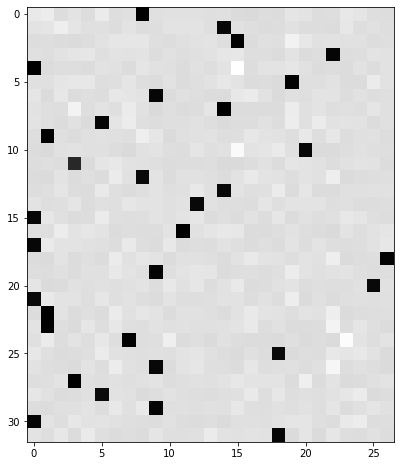

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

In [ ]:
#Bactch Norm
# batchnorm backprop
	dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
	dbnbias = dhpreact.sum(0, keepdim=True)
	dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

In [3]:
# Exercice 4 putting all together:
# Train MLP neural net with your own backward pass


# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)

for i in range(max_steps):

    # minibatch construct
	ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
	Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

	# forward pass
	emb = C[Xb] # embed the characters into vectors
	embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
	hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
	bnmean = hprebn.mean(0, keepdim=True)
	bnvar = hprebn.var(0, keepdim=True, unbiased=True)
	bnvar_inv = (bnvar + 1e-5)**-0.5
	bnraw = (hprebn - bnmean) * bnvar_inv
	hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
	h = torch.tanh(hpreact) # hidden layer
	logits = h @ W2 + b2 # output layer
	loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
	for p in parameters:
		p.grad = None
	#loss.backward()
	# manual backprop! #swole_doge_meme
    # -----------------
	dlogits = F.softmax(logits, 1)
	dlogits[range(n), Yb] -= 1
	dlogits /= n
    # 2nd layer backprop
	dh = dlogits @ W2.T
	dW2 = h.T @ dlogits
	db2 = dlogits.sum(0)
    # tanh
	dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
	dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
	dbnbias = dhpreact.sum(0, keepdim=True)
	dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
	dembcat = dhprebn @ W1.T
	dW1 = embcat.T @ dhprebn
	db1 = dhprebn.sum(0)
    # embedding
	demb = dembcat.view(emb.shape)
	dC = torch.zeros_like(C)
	for k in range(Xb.shape[0]):
		for j in range(Xb.shape[1]):
			ix = Xb[k,j]
			dC[ix] += demb[k,j]
	grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

	# Update
	lr = 0.1 if i < 10000 else 0.01
	for p, grad in zip(parameters, grads):
		p.data += -lr * grad

	# track stats
	if i % 10000 == 0: # print every once in a while
		print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')	
	lossi.append(loss.log10().item())


NameError: name 'vocab_size' is not defined